Loading datasets...
Filtering and canonicalizing SMILES in datasets...


[12:01:49] Explicit valence for atom # 11 N, 4, is greater than permitted
[12:01:49] non-ring atom 15 marked aromatic
[12:01:50] non-ring atom 19 marked aromatic
[12:01:50] non-ring atom 11 marked aromatic
[12:01:50] non-ring atom 0 marked aromatic
[12:01:50] non-ring atom 9 marked aromatic
[12:01:50] non-ring atom 0 marked aromatic
[12:01:50] non-ring atom 10 marked aromatic
[12:01:50] non-ring atom 14 marked aromatic
[12:01:50] non-ring atom 12 marked aromatic
/var/folders/4z/y762cxgx769fwlmj9f5cw6s00000gn/T/ipykernel_23092/24818322.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  caco2['SMILES'] = caco2['SMILES'].apply(canon_smiles)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using:

Number of common SMILES between NX and Caco2 dataset: 61
Number of common SMILES between filtered and Admetica datasets: 27
Number of final common SMILES: 34


/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

+---------+----------+----------+----------+----------+
| Model   |      MAE |      MSE |     RMSE |       R² |
+=========+==========+==========+==========+==========+
| NX      | 0.351543 | 0.201841 | 0.449267 | 0.520728 |
+---------+----------+----------+----------+----------+


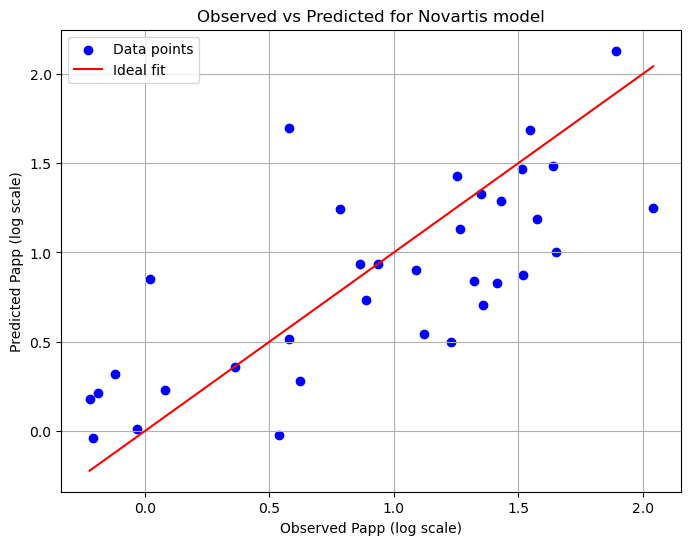

+----------+----------+----------+---------+---------+
| Model    |      MAE |      MSE |    RMSE |      R² |
+==========+==========+==========+=========+=========+
| Admetica | 0.411552 | 0.286792 | 0.53553 | 0.31901 |
+----------+----------+----------+---------+---------+


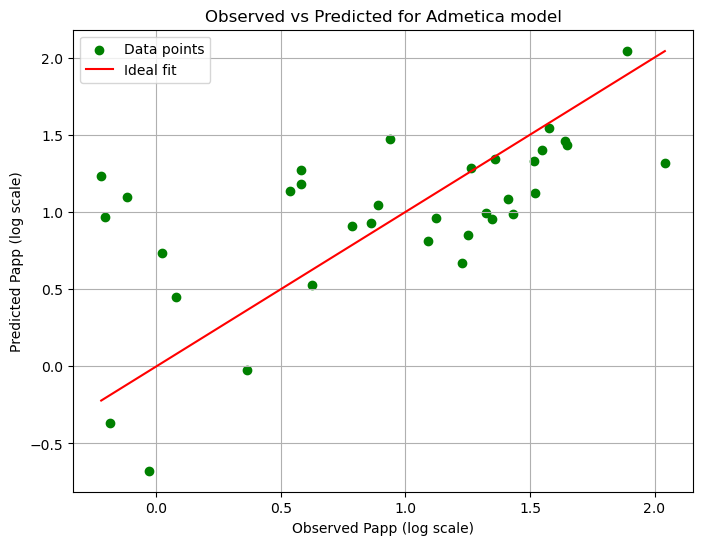

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from rdkit import Chem  # RDKit for SMILES comparison
from tabulate import tabulate
from chemprop import data, featurizers, models
from lightning import pytorch as pl

# Helper function to canonicalize SMILES
def canon_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.MolToSmiles(mol, canonical=True)
        else:
            return float('nan')
    except:
        return float('nan')

# Helper function for SMILES comparison
def compare_smiles(smiles_list1, smiles_list2):
    return list(set(smiles_list1).intersection(smiles_list2))

# Function to compute evaluation metrics
def compute_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    }

# Function to plot observed vs predicted with ideal fit line
def plot_observed_vs_predicted(y_true, y_pred, title, color):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, color=color, label='Data points')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', label='Ideal fit')
    plt.title(title)
    plt.xlabel('Observed Papp (log scale)')
    plt.ylabel('Predicted Papp (log scale)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Load datasets
def load_datasets():
    print("Loading datasets...")
    current_directory = os.getcwd()
    admetica_folder = os.path.abspath(os.path.join(current_directory, '..'))

    nx_path = os.path.join(current_directory, 'novartis/novartis_data.csv')
    admetica_model_path = os.path.join(admetica_folder, 'ADMET/absorption/caco2/caco2.ckpt')
    admetica_dataset_path = os.path.join(admetica_folder, 'ADMET/absorption/caco2/caco2_curated.csv')
    caco2_path = os.path.join(current_directory, 'novartis', 'caco2', 'caco2.csv')

    # Load datasets
    nx_dataset = pd.read_csv(nx_path)
    caco2_dataset = pd.read_csv(caco2_path)
    admetica_dataset = pd.read_csv(admetica_dataset_path)

    return nx_dataset, admetica_model_path, caco2_dataset, admetica_dataset

# Filter Caco2, NX, and Admetica datasets by common SMILES
def filter_by_smiles(nx_dataset, caco2, admetica_dataset):
    print("Filtering and canonicalizing SMILES in datasets...")

    # Clean up Caco2 and Admetica datasets
    caco2 = caco2.dropna(subset=['SMILES'])
    admetica_dataset = admetica_dataset.dropna(subset=['Drug'])
    nx_dataset = nx_dataset.dropna(subset=['smiles'])

    # Canonicalize SMILES in Caco2 and Admetica
    caco2['SMILES'] = caco2['SMILES'].apply(canon_smiles)
    admetica_dataset['Drug'] = admetica_dataset['Drug'].apply(canon_smiles)
    nx_dataset['smiles'] = nx_dataset['smiles'].apply(canon_smiles)

    # Extract SMILES lists from each dataset
    nx_smiles = nx_dataset['smiles']
    caco2_smiles = caco2['SMILES']
    admetica_smiles = admetica_dataset['Drug']

    # Find common SMILES across all three datasets
    common_canon_smiles_nx = compare_smiles(nx_smiles, caco2_smiles)
    print(f"Number of common SMILES between NX and Caco2 dataset: {len(common_canon_smiles_nx)}")

    common_canon_smiles_admetica = compare_smiles(common_canon_smiles_nx, admetica_smiles)
    print(f"Number of common SMILES between filtered and Admetica datasets: {len(common_canon_smiles_admetica)}")

    common_canon_smiles_final = [smile for smile in common_canon_smiles_nx if smile not in common_canon_smiles_admetica]
    print(f"Number of final common SMILES: {len(common_canon_smiles_final)}")

    # Filter datasets by common SMILES
    caco2_filtered = caco2[caco2['SMILES'].isin(common_canon_smiles_final)]
    admetica_filtered = admetica_dataset[admetica_dataset['Drug'].isin(common_canon_smiles_final)]
    nx_filtered = nx_dataset[nx_dataset['smiles'].isin(common_canon_smiles_final)]

    # Sort NX dataset by common SMILES order
    order = {smile: idx for idx, smile in enumerate(common_canon_smiles_final)}
    nx_sorted = nx_filtered.sort_values(by='smiles', key=lambda x: x.map(order)).reset_index(drop=True)
    caco2_filtered = caco2_filtered.sort_values(by='SMILES', key=lambda x: x.map(order)).reset_index(drop=True)
    
    caco2_filtered['Papp(original)a'] = caco2_filtered['Papp(original)a'].apply(lambda x: np.log10(x))

    return caco2_filtered, admetica_filtered, nx_sorted

def load_model(checkpoint_path):
    """Load a pre-trained model from a checkpoint path."""
    try:
        return models.MPNN.load_from_checkpoint(checkpoint_path)
    except Exception as e:
        print(f"Error loading model from {checkpoint_path}: {e}")
        return None

def featurize_smiles(smiles_list):
    """Convert SMILES strings to a dataset and return the dataloader."""
    test_data = [data.MoleculeDatapoint.from_smi(smi) for smi in smiles_list]
    featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
    test_dset = data.MoleculeDataset(test_data, featurizer=featurizer)
    return data.build_dataloader(test_dset, shuffle=False)

def predict_property(model, dataloader):
    """Run inference on the provided model and dataloader."""
    with torch.inference_mode():
        trainer = pl.Trainer(
            logger=False,
            enable_progress_bar=True,
            accelerator="cpu",
            devices=1
        )
        test_preds = trainer.predict(model, dataloader)
        test_preds_flat = [item for sublist in test_preds for item in sublist]
    return test_preds_flat

def calculate_props_admetica(model_path, smiles_list):
    mpnn = load_model(model_path)
    if mpnn is None:
        return None

    test_loader = featurize_smiles(smiles_list)
    test_preds = predict_property(mpnn, test_loader)

    test_preds_list = [pred[0] for pred in test_preds]
    preds = pd.DataFrame({
        'SMILES': smiles_list,
        'Prediction': test_preds_list
    })
    return preds

def main():
    # Load datasets
    nx_dataset, admetica_model_path, caco2_dataset, admetica_dataset  = load_datasets()

    # Filter by SMILES and common values across NX, Caco2, and Admetica
    caco2_filtered, admetica_filtered, nx_sorted = filter_by_smiles(nx_dataset, caco2_dataset, admetica_dataset)
    
    caco2_dir = os.path.join(os.getcwd(), 'novartis', 'caco2')
    caco2_filtered.to_csv(os.path.join(caco2_dir, 'caco2_processed.csv'), index=False)
    nx_sorted.to_csv(os.path.join(caco2_dir, 'novartis_caco2_processed.csv'), index=False)
    
    # Predicted values and ground truth
    y_true_caco2 = caco2_filtered['Papp(original)a']
    y_pred_nx = nx_sorted['pred(Caco-2_LogPapp)']
    smiles_list = caco2_filtered['SMILES']
    preds_admetica = calculate_props_admetica(admetica_model_path, smiles_list)
    y_pred_admetica = preds_admetica['Prediction'] + 6
    
    # Compute metrics for NX model
    nx_metrics_dict = compute_metrics(y_true_caco2, y_pred_nx, "NX")
    nx_metrics = [nx_metrics_dict['Model'], nx_metrics_dict['MAE'], nx_metrics_dict['MSE'], nx_metrics_dict['RMSE'], nx_metrics_dict['R²']]
    
    headers = ["Model", "MAE", "MSE", "RMSE", "R²"]
    print(tabulate([nx_metrics], headers=headers, tablefmt="grid"))

    # Plot Observed vs Predicted for NX models
    plot_observed_vs_predicted(y_true_caco2, y_pred_nx, 'Observed vs Predicted for Novartis model', color='blue')

    # Compute metrics for Admetica model
    admetica_metrics_dict = compute_metrics(y_true_caco2, y_pred_admetica, "Admetica")
    admetica_metrics = [admetica_metrics_dict['Model'], admetica_metrics_dict['MAE'], admetica_metrics_dict['MSE'], admetica_metrics_dict['RMSE'], admetica_metrics_dict['R²']]
    
    print(tabulate([admetica_metrics], headers=headers, tablefmt="grid"))

    # Plot Observed vs Predicted for Admetica model
    plot_observed_vs_predicted(y_true_caco2, y_pred_admetica, 'Observed vs Predicted for Admetica model', color='green')

# Execute main block
main()